## Assignment A3b: Filtering

Please follow the General Assignment Guidelines document on canvas under the Pages for completing this assignment.  When you have completed the assignment, please follow the Submission Instructions.

### Overview

This assignment focuses on concepts in filtering continuous signals with examples of noise removal and signal detection.

### Readings

The following material provides both background and additional context.  It linked in the Canvas page for this assignment.  Refer to these for a more detailed explanation and formal presentation of the concepts in the exercises.  Note that the readings contain a lot more material than what's needed for the exercises.  Feel free to skim or ignore the parts that aren't directly relevant.

- Dusenbery, D. B. (1992). *Sensory Ecology*. Chapter 5-3 Signal Processing.
- Prandoni and Vetterli (2008) *Signal Processing for Communications*.  Chapter 5.

### Learning objectives
- explain how a filtering is a model of linear system
- explain the assumptions of linearity and time-invariance
- derive a recursive filter to implement a moving average
- explain the different between and IIR and an FIR filter
- implement a one dimensional IIR filter
- implement the operation of convolution
- implement low-, high-, and band-pass filters
- explain the impulse response function
- apply filters to different types of signals
- use a filter to detect continuous signals in noise

***
## Exercises

In [1]:
using Pkg; Pkg.activate(".")

  Activating new project at `~/Documents/GitHub/CSDS_364_HW/A3/A3b`


In [3]:
import Pkg; Pkg.add("TikzPictures")

  Installing known registries into `~/.julia`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Gettext_jll ─────────────── v0.21.0+0
   Installed XML2_jll ────────────────── v2.9.12+0
   Installed Libmount_jll ────────────── v2.35.0+0
   Installed Xorg_libXext_jll ────────── v1.3.4+4
   Installed Preferences ─────────────── v1.2.4
   Installed Zstd_jll ────────────────── v1.5.2+0
   Installed TikzPictures ────────────── v3.4.2
   Installed Expat_jll ───────────────── v2.4.4+0
   Installed Xorg_xtrans_jll ─────────── v1.4.0+3
   Installed Libgcrypt_jll ───────────── v1.8.7+0
   Installed Bzip2_jll ───────────────── v1.0.8+0
   Installed Poppler_jll ─────────────── v0.87.0+2
   Installed OpenJpeg_jll ────────────── v2.4.0+0
   Installed Pixman_jll ──────────────── v0.40.1+0
   Installed Libtiff_jll ─────────────── v4.3.0+0
   Installed LZO_jll ─────────────────── v2.10.1+0
   Installed Libffi_jll ──────────────── v3.2.2+1
   Instal

### 1. Filtering

Filtering is a model of how a system responds to a signal.  The goal is not only to describe the relationship between the input and output, but also to design the characteristics of system itself so that it produces desired outputs.  The input output relationship is not just an instantaneous function of time, e.g. $y(t) = f(x(t))$.  Instead, filtering can be described as a transformation of one signal to another.  We will see below that the response of the system can be characterized by the function $h[n]$.  It is common to represent the flow of the signal through the system with a block diagram:

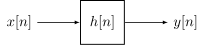

In [4]:
using TikzPictures

fig = TikzPicture(L"""
% define elements
\tikzstyle{block} = [draw, shape=rectangle, minimum height=3em, minimum width=3em, node distance=2cm, line width=1pt]
    
% create nodes
\node at (-2.0,0) (input)  {$x[n]$};
\node     [block] (h)      {$h[n]$};
\node at (2.0,0)  (output) {$y[n]$};

% connect
\draw[->] (input) -- (h);
\draw[->] (h) -- (output);
""", options="scale=1.5, thick, transform shape, auto, >=latex")

### 1a. A moving average filter

One of the simplest computations to perform is an average, to do, for example, noise reduction.  A system that outputs (in discrete steps) the average of the last $M$ samples is described mathematically by
$$
y_M[n] = \frac{1}{M} \sum_{k=0}^{M-1} x[n-k]
$$
To implement this in a physical system would seem to require a memory of the previous $M-1$ input values, but it is possible to do the equivalent computation simply by using feedback, i.e. the previous output.  In terms of a block diagram, we can represent the signal flow in terms of a feed-forward part and a feed-back part.

Use the equation above to derive the following expression
$$
y_M[n] = \lambda y_{M-1}[n-1] + (1-\lambda) x[n]
$$
Then make an approximation to get
$$
y[n] = \lambda y[n-1] + (1-\lambda) x[n]
$$
This is now a just a function of the current input and the previous output, so the filter can be described as a simple feedback system.  What is the behavior for different values of $\lambda$?

This equation can be represented in a diagram:

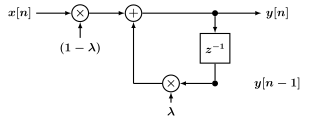

In [5]:
using TikzPictures

# A first order circuit

fig = TikzPicture(L"""
    % The default tikz rendering is too small and thin in a jupyter notebook.
    % We also need the option (in options=, below) "font=\\boldmath" to get more legible fonts.
    \def\nodefontsize{\large} % match katex
    \pgfsetlinewidth{1.1pt}   % bold lines

    % define element styles
    \tikzstyle{var}    = [node font=\nodefontsize]
    \tikzstyle{branch} = [fill, shape=circle, minimum size=6pt, inner sep=0pt, outer sep=0pt]
    \tikzstyle{corner} = [fill, minimum size=0pt, inner sep=0pt, outer sep=0pt]
    \tikzstyle{block}  = [draw, shape=rectangle, minimum height=2.5em, minimum width=2.5em, node font=\nodefontsize]
    \tikzstyle{sum}    = [draw, circle, node font=\nodefontsize, inner sep=1pt]
    \tikzstyle{prod}   = [draw, circle, node font=\nodefontsize, inner sep=1pt]

    % define macros for different nodes types
    \def\vn#1#2{\node [var]    (#1) {#2};}        % variable node
    \def\bn#1  {\node [branch] (#1) {};}
    \def\cn#1  {\node [corner] (#1) {};}          % corner node (without branch)
    \def\sn#1  {\node [sum]    (#1) {$+$};}
    \def\pn#1  {\node [prod]   (#1) {$\times$};}
    \def\dn#1  {\node [block]  (#1) {$z^{-1}$};}  % delay node

    % create nodes
    \matrix[row sep=10pt, column sep=20pt] {
    \vn{i11}{$x[n]$} & \pn{p12}                & \sn{s13} &                     & \bn{b15} & \vn{o16}{$y[n]$} \\
                     & \vn{v22}{$(1-\lambda)$} &          &                     & \dn{d25} & \\
                     &                         & \cn{c33} & \pn{p34}            & \bn{b35} & \vn{o36}{$y[n-1]$} \\
                     &                         &          & \vn{v44}{$\lambda$} &          & \\
    };

    % connect nodes by paths
    \foreach \x [remember=\x as \lastx (initially i11)] in {p12, s13, o16}{
        \draw[->] (\lastx) -- (\x);
    }
    \foreach \x/\tip [remember=\x as \lastx (initially b15)] in {d25/->, b35/-, p34/->, c33/-, s13/->}{
        \draw[\tip] (\lastx) -- (\x);
    }

    % connect variables
    \foreach \x/\y in {v22/p12, v44/p34}{
        \draw[->] (\x) -- (\y);
    }

    % Normally, these options make the whole plot larger, thicker, and more legible,
    % but they don't seem to work with matrix.
    % options="scale=1.25, thick, transform shape, auto, thick"
    % Instead, we just use font=\\boldmath (note the escaped \) to make it look more like katex.
""", options="font=\\boldmath, >=latex")

The paths represent the signal flow and the  nodes represent the operations (multiplication, addition, and delay).  Notice how the output is feedback and added (after scaling) to the scaled input.  $z^{-1}$ is standard notation for representing a delay of one sample (for reasons that go beyond the scope of this course, but it's from the time shift property of the z-transform).  This is also just a memory cell that holds the last value of the output, i.e. $y[n-1]$.

### 1b. Implementation

Write a function `movingavg(x; λ=0.5)` which takes a vector `x` and returns the moving average as described above.  Assume that the input `x` is zero before the first sample.

To test your function, we could use just random noise, but we can make it a little more interesting by smoothing a random process.  Write a function `randprocess(N; σ=1)` which produces a waveform of length `N` where the next sample is randomly perturbed from the previous according to
$$
x_i \sim \mathcal{N}(x_{i-1}, \sigma)
$$
Note that this isn't a function of time, only the previous sample.  

Show an examples of random process vector `x`  with the waveform resulting from different values $\lambda$.  Use your code from A3a to generate a noisy sine wave, and demonstrate how the moving average smooths the signal.

### 1c. System delay
You will notice that the filtered waveform is not exactly superimposed on the noisy signal.  Why is that?  What can you say about the response lag?  Plot smoothed noisy sine waves again, but this time with delay adjusted for a centered average.

### 2. IIR Filters

#### First order IIR filter

We can generalize the filter above to be a function of both the previous output and the previous input.  In addition, we can have arbitrary values for the multiplicative factors (coefficients).

$$
y[n] =  a_1 y[n-1] + b_0 x[n] + b_1 x[n-1]
$$

It can be represented with the following block diagram

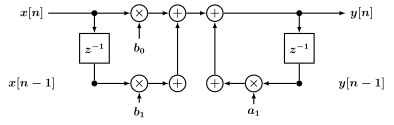

In [6]:
fig = TikzPicture(L"""
    % The default rendering is too small and thin in a jupyter notebook.
    % We also need the option (in options=, below) "font=\\boldmath" to get more legible fonts.
    \def\nodefontsize{\large}
    \pgfsetlinewidth{1.1pt}
    

    % define element styles
    \tikzstyle{var}    = [node font=\nodefontsize]
    \tikzstyle{block}  = [draw, shape=rectangle, minimum height=2.5em, minimum width=2.5em, node font=\nodefontsize]
    \tikzstyle{branch} = [fill, shape=circle, minimum size=6pt, inner sep=0pt, outer sep=0pt]
    \tikzstyle{sum}    = [draw, circle, node font=\nodefontsize, inner sep=1pt]
    \tikzstyle{prod}   = [draw, circle, node font=\nodefontsize, inner sep=1pt]

    % define macros for different nodes types
    \def\vn#1#2{\node [var]    (#1) {#2};} % variable node
    \def\bn#1  {\node [branch] (#1) {};}
    \def\sn#1  {\node [sum]    (#1) {$+$};}
    \def\pn#1  {\node [prod]   (#1) {$\times$};}
    \def\dn#1  {\node [block]  (#1) {$z^{-1}$};} % delay node

    % create nodes
    \matrix[row sep=10pt, column sep=20pt] {
        \vn{i11}{$x[n]$}   & \bn{b12} & \pn{p13}        & \sn{s14} & \sn{s15} &                 & \bn{b17} & \vn{o18}{$y[n]$} \\
                           & \dn{d22} & \vn{v23}{$b_0$} &          &          &                 & \dn{d27} & \\
        \vn{i31}{$x[n-1]$} & \bn{b32} & \pn{p33}        & \sn{s34} & \sn{s35} & \pn{p36}        & \bn{b37} & \vn{o38}{$y[n-1]$} \\
                           &          & \vn{v43}{$b_1$} &          &          & \vn{v46}{$a_1$} &          & \\
    };

    % connect nodes by paths
    \foreach \x [remember=\x as \lastx (initially i11)] in {p13, s14, s15, o18}{
        \draw[->] (\lastx) -- (\x);
    }
    \foreach \x/\tip [remember=\x as \lastx (initially b12)] in {d22/->, b32/-, p33/->, s34/->, s14/->}{
        \draw[\tip] (\lastx) -- (\x);
    }
    \foreach \x/\tip [remember=\x as \lastx (initially b17)] in {d27/->, b37/-, p36/->, s35/->, s15/->}{
        \draw[\tip] (\lastx) -- (\x);
    }

    % connect variables
    \foreach \x/\y in {v23/p13, v43/p33, v46/p36}{
        \draw[->] (\x) -- (\y);
    }

    % Normally, these options make the whole plot larger, thicker, and more legible,
    % but they don't seem to work with matrix.
    % options="scale=1.25, thick, transform shape, auto, thick"
    % Instead, we just use font=\\boldmath (note the escaped \) to make it look more like katex.
""", options="font=\\boldmath, >=latex")

This is a simple case of a general class of filters called "IIR filters" for infinite impulse response, which these filters have due to the feedback.  Different settings of the parameters will result in different response properties.  This particular example is called a first order IIR filter, because it's response can be characterized as a ratio of first order polynomials.  That analysis is beyond the scope of this course (and is actually a whole course in itself), so here we will just focus on a few examples and their basic response properties.

#### Second order IIR filter

A second-order IIR filter is defined by the equation
$$
y[n] = a_1 y[n-1] + a_2 y[n-2] + b_0 x[n] + b_1 x[n-1] + b_2 x[n-2]
$$
It adds a second set of delays and coefficients and can be characterized by a ratio of second order polynomials.  The block diagram is

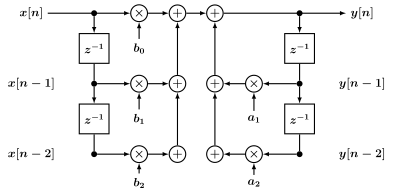

In [7]:
fig = TikzPicture(L"""
    % The default rendering is too small and thin in a jupyter notebook.
    % We also need the option (in options=, below) "font=\\boldmath" to get more legible fonts.
    \def\nodefontsize{\large}
    \pgfsetlinewidth{1.1pt}
    

    % define element styles
    \tikzstyle{var}    = [node font=\nodefontsize]
    \tikzstyle{block}  = [draw, shape=rectangle, minimum height=2.5em, minimum width=2.5em, node font=\nodefontsize]
    \tikzstyle{branch} = [fill, shape=circle, minimum size=6pt, inner sep=0pt, outer sep=0pt]
    \tikzstyle{sum}    = [draw, circle, node font=\nodefontsize, inner sep=1pt]
    \tikzstyle{prod}   = [draw, circle, node font=\nodefontsize, inner sep=1pt]

    % define macros for different nodes types
    \def\vn#1#2{\node [var]    (#1) {#2};} % variable node
    \def\bn#1  {\node [branch] (#1) {};}
    \def\sn#1  {\node [sum]    (#1) {$+$};}
    \def\pn#1  {\node [prod]   (#1) {$\times$};}
    \def\dn#1  {\node [block]  (#1) {$z^{-1}$};} % delay node

    % create nodes
    \matrix[row sep=10pt, column sep=20pt] {
        \vn{i11}{$x[n]$}   & \bn{b12} & \pn{p13}        & \sn{s14} & \sn{s15} &                 & \bn{b17} & \vn{o18}{$y[n]$} \\
                           & \dn{d22} & \vn{v23}{$b_0$} &          &          &                 & \dn{d27} & \\
        \vn{i31}{$x[n-1]$} & \bn{b32} & \pn{p33}        & \sn{s34} & \sn{s35} & \pn{p36}        & \bn{b37} & \vn{o38}{$y[n-1]$} \\
                           & \dn{d42} & \vn{v43}{$b_1$} &          &          & \vn{v46}{$a_1$} & \dn{d47} & \\
        \vn{i51}{$x[n-2]$} & \bn{b52} & \pn{p53}        & \sn{s54} & \sn{s55} & \pn{p56}        & \bn{b57} & \vn{o58}{$y[n-2]$} \\
                           &          & \vn{v63}{$b_2$} &          &          & \vn{v66}{$a_2$} &          & \\
    };

    % connect nodes by paths
    \foreach \x [remember=\x as \lastx (initially i11)] in {p13, s14, s15, o18}{
        \draw[->] (\lastx) -- (\x);
    }
    \foreach \x/\tip [remember=\x as \lastx (initially b12)] in {d22/->, b32/-, p33/->, s34/->, s14/->}{
        \draw[\tip] (\lastx) -- (\x);
    }
    \foreach \x/\tip [remember=\x as \lastx (initially b17)] in {d27/->, b37/-, p36/->, s35/->, s15/->}{
        \draw[\tip] (\lastx) -- (\x);
    }
    \foreach \x/\tip [remember=\x as \lastx (initially b32)] in {d42/->, b52/-, p53/->, s54/->, s34/->}{
        \draw[\tip] (\lastx) -- (\x);
    }
    \foreach \x/\tip [remember=\x as \lastx (initially b37)] in {d47/->, b57/-, p56/->, s55/->, s35/->}{
        \draw[\tip] (\lastx) -- (\x);
    }


    % connect variables
    \foreach \x/\y in {v23/p13, v43/p33, v63/p53, v46/p36, v66/p56}{
        \draw[->] (\x) -- (\y);
    }

    % Normally, these options make the whole plot larger, thicker, and more legible,
    % but they don't seem to work with matrix.
    % options="scale=1.25, thick, transform shape, auto, thick"
    % Instead, we just use font=\\boldmath (note the escaped \) to make it look more like katex.
""", options="font=\\boldmath, >=latex")

#### General IIR difference equation

The standard form of the general $nth$ order constant coefficient difference equation is
$$
\sum_{k=0}^{N-1} a_k y[n-k] = \sum_{k=0}^{M-1} b_k x[n-k]
$$

Usually it is assumed that $a_0 = 1$, and re-written in the form
$$
y[n] = \sum_{k=0}^{M-1} b_k x[n-k] - \sum_{k=1}^{N-1} a_k y[n-k]
$$
Note that in the second sum now starts at $k=1$.  This might seem backwards, but it's the standard, and when there's a standard it behooves you to follow it. So, note that the signs of the $a_k$ coefficients have changed sign from the 1st and 2nd order equations above.  A saving grace is that this form avoids minus signs in the spectral analysis equations, but we won't cover that here.

### 2a. Implementation

Write a function `filterIIR(x; a, b)` which accepts coefficient vectors `a` and `b` of arbitrary length, with the vector `a` starting at $a_1$ and the vector `b` starting at $b_0$.  It should return an output that is the same length as the input.  Assume that the input waveform prior to the first value was zero.  Show that your function reproduces the output from the moving average filter.

### 2b. First order low- and high-pass IIR filters

Use your function above to implement two filters with the coefficients $a = [-0.9]$ and $b = [0.1]$.  Illustrate the filter by applying it to a random process waveform and overlaying the filter output on the input.  

We can think of waveforms as being composed of a spectrum of frequencies, i.e. the sum of oscillations of different frequencies.  A speech waveform, for example, might be composed of a small number of frequencies, and so it is a more compact way to describe the structure in the signal than the time-varying waveform.  We will see later how to compute the spectral representation for arbitrary signals.  In this example, we can think of the random process as being composed of a large set of frequencies, with rapid variations characterized by higher frequencies and slower variations by lower frequencies.

This filter setting is an example of a **low-pass filter**, because it passes the lower frequency components while filtering out the higher frequencies.

Now use the coefficients $a = [0.9]$ and $b = [0.1]$ and contrast the effect by applying it to the same waveform.  This is an example of a **high-pass filter** because it passes the higher frequency components and filters out the lower frequencies.

Contrast the first order difference equations of these two filters.  How is each achieving the result?

### 2c. Second order bandpass filters

Illustrate the filtering a signal composed of uniform random noise on $[-1, 1]$ using the following coefficients
$$
\begin{aligned}
a &= [-1.265, 0.81] \\
b &= [0.135]
\end{aligned}
$$

Now do the same for the following coefficients
$$
\begin{aligned}
a &= [-1.702, 0.81] \\
b &= [0.063]
\end{aligned}
$$

What you should see is that these 2nd order filters filter out both the low and the high frequency components.  These are called **bandpass** filters.  Contrast the two IIR difference equations and provide an interpretation of how they are computing the result.

### 2d. Characterizing the filter response

We have seen how filtering can process the signal to smooth it or remove low-frequency variation.  Here we want to focus on this question: If we are given an unknown system, how would we characterize its response?  Is there a way to measure the input-output relationship in a systematic way?

We will discuss the analytic methods for this at a future point in the course.  Here, we simply want to develop some intuition.  Generate a noisy sine wave like above using a sampling frequency of 2 kHz and a signal duration of 100 msecs.  Using the filter coefficients in 2c, make a figure consisting of a 4x4 matrix of plots in which you vary the frequency (from low to high) over the rows and the noise level (from high to low) over the columns. Make sure that the y-axes have the same limits, an try to choose frequencies that contrast the responses.  Make one plot each for the two sets of filter coefficients in 2c.

What can you observe about the relation between the output an input?

Now make a plot where you systematically vary an input frequency (without noise) from 0 to the Nyquist frequency.  Plot of the output signal power as a function of frequency.  How would you characterize the system response?

### 3. The impulse response function

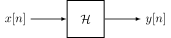

In [8]:
using TikzPictures

fig = TikzPicture(L"""
% define elements
\tikzstyle{block} = [draw, shape=rectangle, minimum height=3em, minimum width=3em, node distance=2cm, line width=1pt]
    
% create nodes
\node at (-2.0,0) (input)  {$x[n]$};
\node     [block] (H)      {$\mathcal{H}$};
\node at (2.0,0)  (output) {$y[n]$};

% connect
\draw[->] (input) -- (H);
\draw[->] (H) -- (output);
""", options="scale=1.25, thick, transform shape, auto, >=latex")

The essential property of linear time-invariant (LTI)systems is that it is possible to predict the system response $y[n]$ to *any* input $x[n]$ using just a single function, called the *impulse response function*.  Naturally, this is derived assuming properties of linearity and time-invariance.  Here we assume the response of the system is determined by $\mathcal{H}$

$$
y[n] = \mathcal{H}(x[n])
$$

Note that this does not imply the $nth$ sample of the output is a function of only the $nth$ sample of the input.  As we have seen above, the output of an $nth$ order system is a function of the previous $n$ samples.  

Here, we have use a common but notationally imprecise shorthand, i.e. using $x[n]$ to refer to the whole waveform and also the value of that waveform at the $nth$ sample.  This is analogous to what we mean when we use $f(t)$ to refer to both the function $f$ or its value at time $t$, depending on the context.  Analogous to when we say the function $f(t)$ we say the sequence $x[n]$.

#### Linearity

The assumption that the system is linear means
$$
\mathcal{H}(\alpha x_1[n] + \beta x_2[n]) 
= \alpha\mathcal{H}(x_1[n]) + \beta\mathcal{H}(x_2[n])
$$

This is also called the principle of superposition.  This can be generalized to the superposition of many inputs.  If
$$
x[n] = \sum_k \alpha_k x_k[n]
$$
and the individual system responses are
$$
y_k[n] = \mathcal{H}(x_k[n])
$$
then the output will be the superposition of the individual responses
$$
y[n] = \sum_k \alpha_k y_k[n]
$$

The assumptions of linearity is natural for sounds since sound pressure is additive.  It also works for electrical circuits since both voltage and current are also additive.  For images, however, the assumption of linearity can be questioned.  The property of occlusion means that the representation of two objects is not the same as the addition of their individual representations.  Images might be invariant in the time axis, but they are not in the z-axis due to perspective distortion.  We want to keep a clear distinction between additive features, which we might be able to detect using the methods describe here, and the causal structures of sounds and images, which require non-linear approaches using algorithms and inference.

#### Time invariance
The assumption that the system is time invariant (also called shift-invariant) means
$$
y[n] = \mathcal{H}(x[n]) \iff \mathcal{H}(x[n - n_0]) = y[n - n_0]
$$

This says that a shift in the input implies a corresponding shift in the output.  This assumption could be violated if the system *itself* changes over time, e.g. due to energy depletion or other non-stationary properties.

### 3a. Deriving the impulse response function

The reproducing formula
$$
x[n] = \sum_{k=-\infty}^{\infty} x[k] \delta[n-k]
$$
represents an arbitrary signal $x[n]$ as a sum of impulses occuring at sample $n-k$.  Explain how the assumptions of linearity and time-invariance are necessary to derive the following formula
$$
y[n] = \mathcal{H}(x[n]) = \sum_{k=-\infty}^{\infty} x[k] h[n-k]
$$
What is the definition of $h[n]$?  Explain how this shows that we can predict the system response to an arbitrary input.

### 3b. Impulse responses

Plot the impulse responses for the systems used thus far. How can you interpret the impulse response functions in terms of a weighted average to explain the system response?

### 4. Filtering with convolution

The formula for the impulse response function describes the mathematical operation of **convolution**
$$
y[n] = \sum_{k=-\infty}^{\infty} x[k] h[n-k]
$$

Convolution is commonly written with the $*$ operator
$$
y[n] = x[n] * h[n]
$$
Aside: Perhaps because keyboards lacked a $\times$ symbol (and a $\div$), the asterisk was appropriated for multiplication in computer programs.  The convolution operation does involve multiplication, but even though it looks like element-wise multiplication, it is very much not
$$
x[n] * h[n] \neq x[n] \times h[n]
$$
This is the same shorthand notation discussed above.  A more precise notation for convolution is
$$
y[n] = (x*h)[n]
$$
which at least suggests that we're convolving the waveforms $x$ and $h$ and *then* taking the $nth$ sample of the result.  

#### Non-causal filters

Note that in the convolution sum $k$ goes from $-\infty$ to $\infty$.  For a time-varying signal, values of $x[k>n]$ are in the *future*, and so can't be implemented in a real time system, but for signals that are stored in memory this obviously isn't an issue. This is commonly used to define filters centered on the input sample.

### 4a. Implementing convolution 

Write a function `convolve(x; h=[1], h0=1` that convolves the signal `x` with the impulse response function `h` (also called a convolution kernel).

Note that in the convolution equation above $k$ is an offset index, not a sample index of the array $h[n]$, because $k$ ranges from $-\infty$ to $\infty$.  When you implement this equation, you will need convert the offset $n-k$ to an index of the array $h$ using the argument $h0$.  

Some convolution kernels like the Gabor are defined around zero, while others like a gammatone start at zero.  You can use $h0$ to control whether the convolution is centered around $x[n]$, which is inherently non-causal because it's using values $x[k > n]$, or to make the convolution causal so it only uses values $x[k \leq n]$.  The default value $h0=1$ above assumes a causal filter and 1-based indexing.

Show that convolving a signal with the impulse response function you obtained in 3b produces the same result as the IIR filter.

### 4b. FIR filtering

A filter that uses convolution and a kernel to compute the result is called an **FIR filter** which stands for finite impulse response.  Show that your previous result can be approximated using only the first $k$ values of $h[k]$ that are significantly different from zero.

Use your function to compute the convolution of the same noise signal you used in 2d for the bandpass filters, but this time with using a Gabor function with frequency 250 Hz and $\sigma=3/250$.  Center the filter using the $h_0$ argument.

### 4c. Using matched filters to detect signals in noise

Use your code from A3a to generate a gammatone function in different levels of noise.  Show how you can detect this signal using a "matched" gammatone filter, i.e. a convolution kernel with the same parameters as the signal you are trying to detect.  Comment on the effectiveness of this approach vs threshold detection.

### Tests and self checks

You should write tests for your code and make plots to verify that your implementations are correct.  After you submit your draft version, take the self check quiz.  This will give you feedback so you can make corrections and revisions before you submit your final version.  For this assignment the quiz will consist primarily of the submitting the assignment figures.

***
### Submission Instructions

Please refer to the Assignment Submission Instructions on canvas under the Pages tab.